In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs

In [ ]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38551 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:32967' processes=7 threads=14, memory=63.00 GiB>

In [3]:
#load in pascal data

In [4]:
data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"

In [5]:
#load in LSM
LSM = xr.open_dataset(data_dir+"echam_mesh_mask_oce.nc").nmask.rename(
    {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')[::-1]


In [22]:
def load_sintex(file):
    data_dir = "/g/data/e14/sm2435/Pascal_runs/Pacemakers/"
    var = file.split('_')[-1].split('.')[0]
    ds = xr.open_dataset(data_dir+file, use_cftime=True, chunks = {"time":240}).rename(
        {'lon': 'longitude', 'lat': 'latitude'}).sortby('latitude')
    ds = ds.tsurf
    ds = ds.where(LSM==1)
    ds = ds.compute()
    ds = roll_longitude(ds)
    return ds

In [23]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['longitude'] = (df.coords['longitude']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.longitude)
    
    return df

In [25]:
sinctrl = load_sintex("REFADA_1m_000101_021012_tsurf.nc")

In [26]:
sinoc = load_sintex("FTP_1m_000101_005012_tsurf.nc")

In [27]:
sinmc = load_sintex("FTPC_1m_000101_011012_tsurf.nc")

In [28]:
sinctrl_sd = sinctrl.groupby("time.month").std("time")

In [29]:
sinoc_sd = sinoc.groupby("time.month").std("time")
sinmc_sd = sinmc.groupby("time.month").std("time")

In [40]:
lat_limits = (-30, 40)
lon_limits = (-150, 120) 

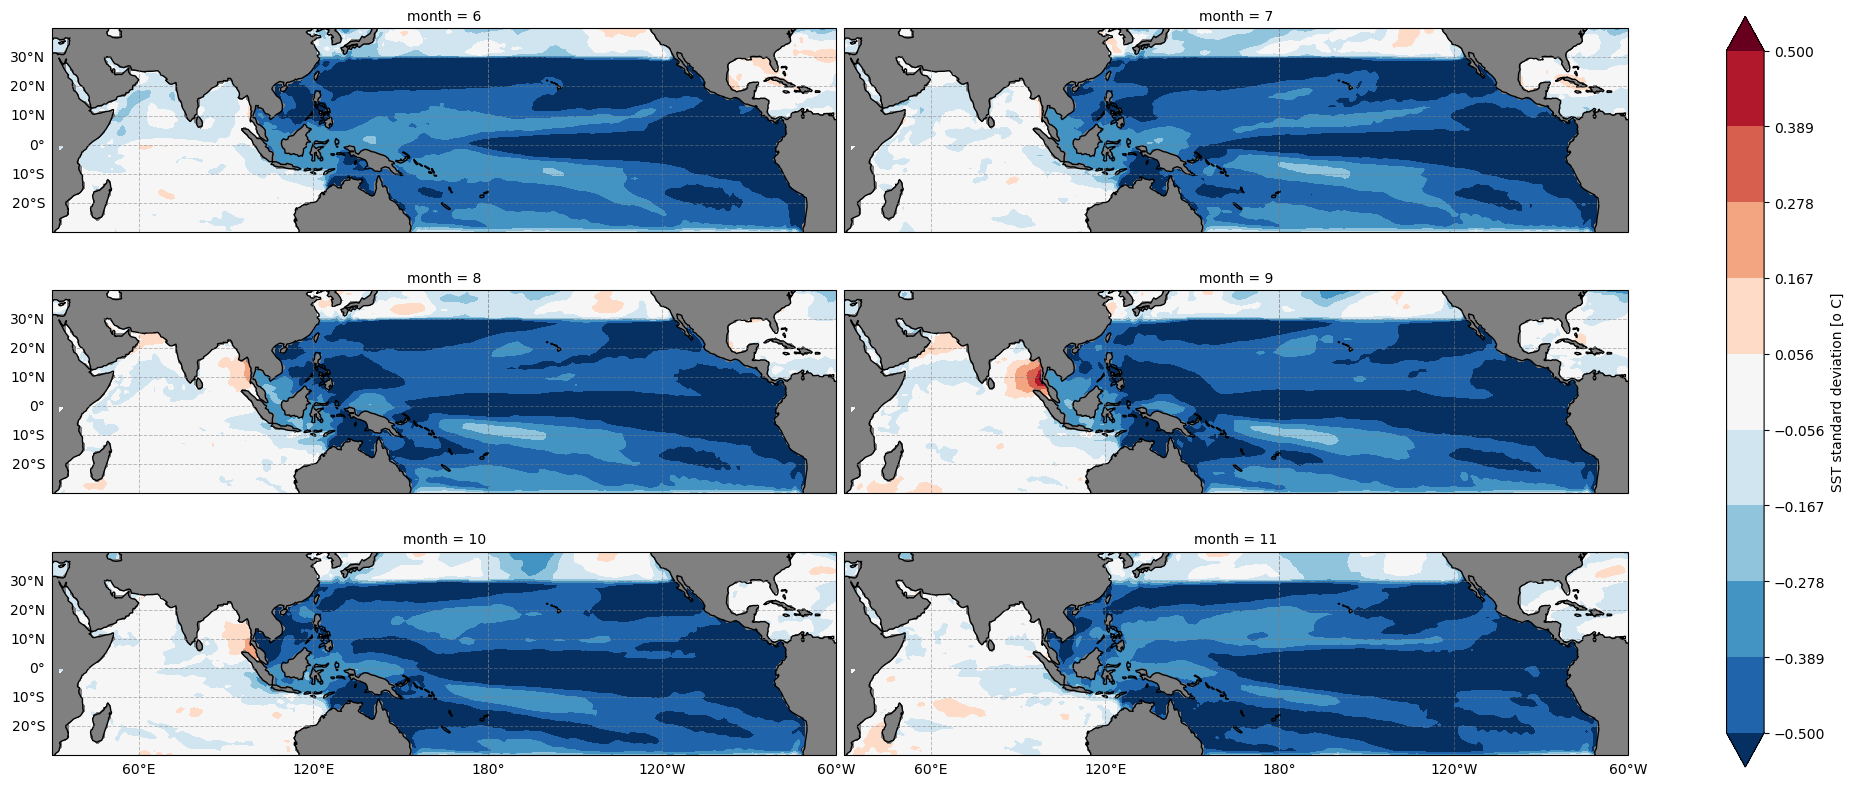

In [41]:
fg = (sinmc_sd - sinctrl_sd)[5:11].plot.contourf(col="month", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(20,8), vmin = -0.5, vmax = 0.5, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST standard deviation [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3]:
        gl.bottom_labels = False
    if i in [1,3,5]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

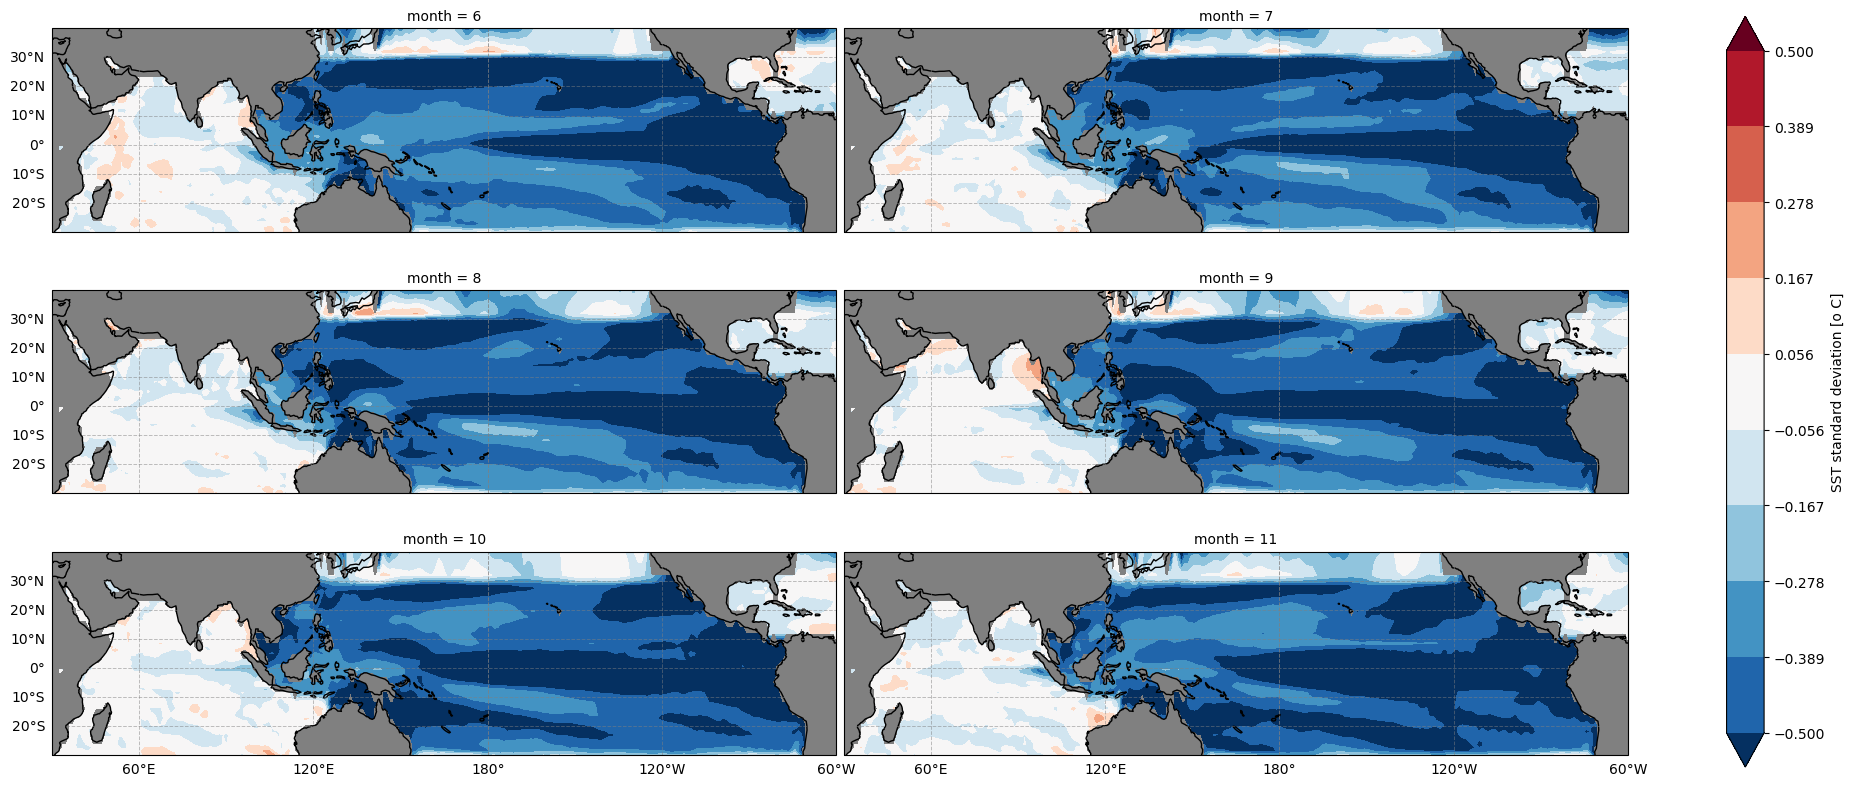

In [42]:
fg = (sinoc_sd - sinctrl_sd)[5:11].plot.contourf(col="month", col_wrap = 2, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(20,8), vmin = -0.5, vmax = 0.5, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST standard deviation [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3]:
        gl.bottom_labels = False
    if i in [1,3,5]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

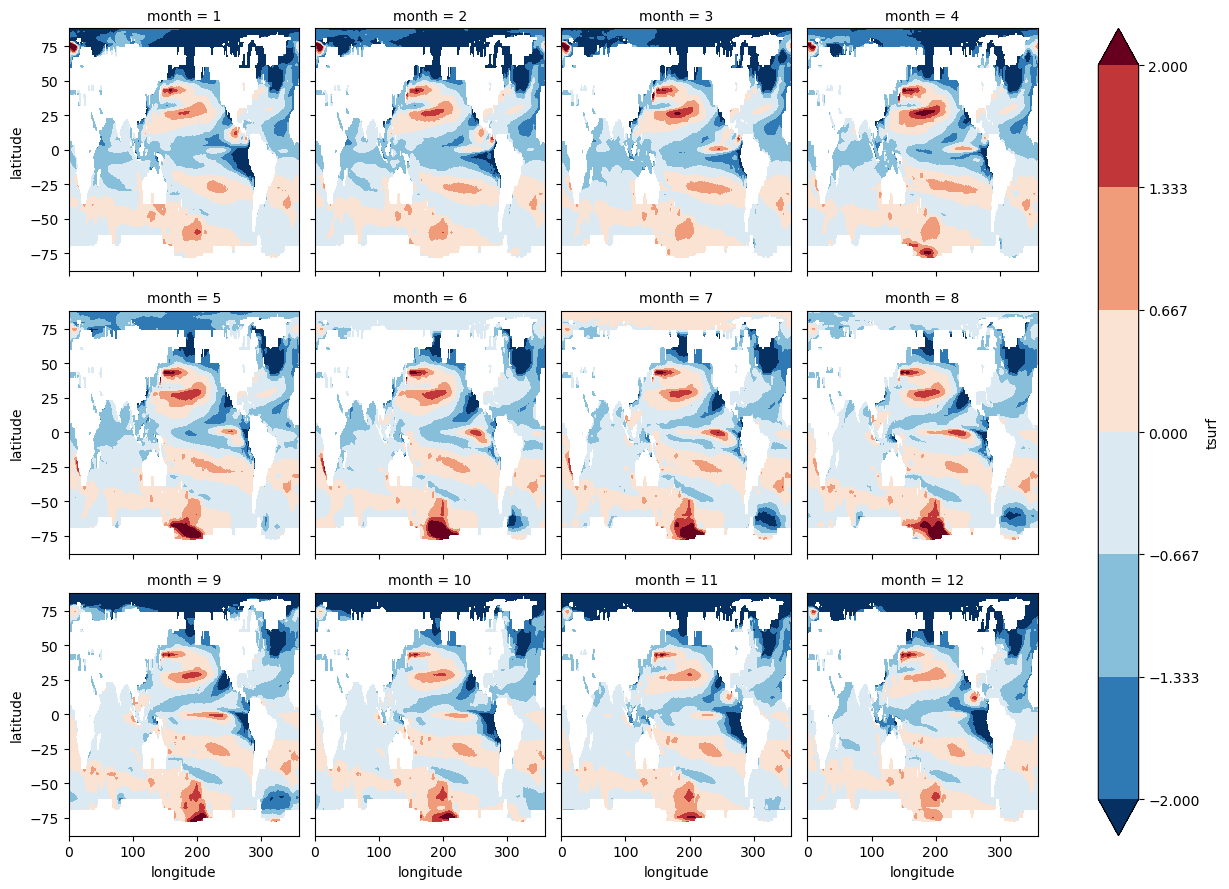

In [49]:
(sinoc.groupby("time.month").mean("time") - sinctrl.groupby("time.month").mean("time")).plot.contourf(col = "month", col_wrap = 4, vmin = -2)